In [1]:
target = "data/bay/0001.jpeg"

In [2]:
from imageio import imread
import numpy as np
from skimage import color, filters, img_as_float
import math

In [3]:
img = img_as_float(imread(target))

In [4]:
img.shape

(386, 687, 3)

In [5]:
tile_w = int(img.shape[0]/5)
tile_h = int(img.shape[1]/5)

In [6]:
tile_w, tile_h

(77, 137)

In [7]:
tile = img[0:tile_w, 0:tile_h, :]

In [8]:
tile.shape

(77, 137, 3)

# Color Moments

In [9]:
def calc_moment3(arr, moment1):
    cubed = np.mean((tile[:, :, 0]-moment1)**3)
    return math.pow(abs(cubed),1/3) * (1,-1)[cubed<0]

In [10]:
def calc_moments(arr):
    moment1 = np.mean(arr)
    moment2 = np.mean((arr-moment1)**2)**(1/2)
    moment3 = calc_moment3(arr, moment1)
    return moment1, moment2, moment3

In [11]:
def calc_4_moments(rgbarr):
    r1, r2, r3 = calc_moments(rgbarr[:, :, 0])
    g1, g2, g3 = calc_moments(rgbarr[:, :, 1])
    b1, b2, b3 = calc_moments(rgbarr[:, :, 2])
    gray = color.rgb2gray(rgbarr)
    gr1, gr2, gr3 = calc_moments(gray)
    return [r1, r2, r3, g1, g2, g3, b1, b2, b3, gr1, gr2, gr3]

In [12]:
calc_4_moments(tile)

[0.37209400017472155,
 0.10217063437619424,
 -0.09780083132038393,
 0.60834722741120328,
 0.069683966722592888,
 -0.2781541238099151,
 0.8166978005535328,
 0.05321479042159858,
 -0.4683674599313368,
 0.5731654929470128,
 0.073980597551597832,
 -0.2485871934295749]

# DOOG filter


Based on "Preattentive texture discrimination with early vision mechanisms", Fig. 2.

In [16]:

def G(y0, sigmax, sigmay, x, y):
    # The definition of G seems wrong, I refer original Yang's paper.
    # return (1/(2*math.pi* sigmax*sigmay)) *np.exp(- (x**2) + (y- y0/sigmay)**2)
    dimx = len(x)
    dimy = len(y)
    return (1/(2*math.pi* sigmax*sigmay)) *np.exp(- (1/2) * (((x/sigmax)**2).reshape(1, dimx) + (((y- y0)/sigmay)**2).reshape(dimy, 1)))

In [13]:
np.arange(-5, 5)

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

In [27]:
gausres = G(1.5, 2, 2, np.arange(-5, 5), np.arange(-5, 5))

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

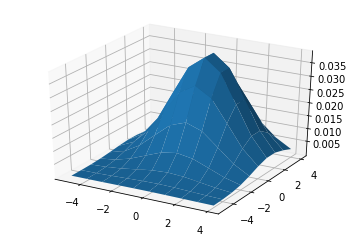

In [28]:

X,Y=np.meshgrid(np.linspace(-5,4,10),np.linspace(-5,4,10));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, gausres)
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [31]:
def DOOG2(x, y, sigma, r=3):
    sigmay = sigma
    sigmax = r*sigma
    ya = sigma
    yc = -sigma
    return -G(ya, sigmax, sigmay, x, y) + 2*G(0, sigmax, sigmay, x, y) - G(yc, sigmax, sigmay, x, y)

In [32]:
DOOG2(np.arange(0, 5), np.arange(0, 5), 4, 2)

array([[ 0.00391391,  0.00388345,  0.00379349,  0.00364817,  0.00345402],
       [ 0.0036098 ,  0.00358171,  0.00349874,  0.0033647 ,  0.00318564],
       [ 0.00277449,  0.0027529 ,  0.00268913,  0.00258611,  0.00244848],
       [ 0.00161234,  0.0015998 ,  0.00156274,  0.00150287,  0.00142289],
       [ 0.00038658,  0.00038357,  0.00037468,  0.00036033,  0.00034115]])

In [33]:
def DOOG2_weight(sigma, r=3, truncate=4):
    # similar filter size logic as filters.gaussian of scipy.
    lw = int(truncate * sigma + 0.5)
    return DOOG2(np.arange(-lw, lw+1), np.arange(-lw, lw+1), sigma, r)

In [34]:
DOOG2_weight(7.5)

array([[ -4.04866735e-06,  -4.29159896e-06,  -4.54013015e-06, ...,
         -4.54013015e-06,  -4.29159896e-06,  -4.04866735e-06],
       [ -5.93224151e-06,  -6.28819295e-06,  -6.65234908e-06, ...,
         -6.65234908e-06,  -6.28819295e-06,  -5.93224151e-06],
       [ -8.52716584e-06,  -9.03882017e-06,  -9.56226812e-06, ...,
         -9.56226812e-06,  -9.03882017e-06,  -8.52716584e-06],
       ..., 
       [ -8.52716584e-06,  -9.03882017e-06,  -9.56226812e-06, ...,
         -9.56226812e-06,  -9.03882017e-06,  -8.52716584e-06],
       [ -5.93224151e-06,  -6.28819295e-06,  -6.65234908e-06, ...,
         -6.65234908e-06,  -6.28819295e-06,  -5.93224151e-06],
       [ -4.04866735e-06,  -4.29159896e-06,  -4.54013015e-06, ...,
         -4.54013015e-06,  -4.29159896e-06,  -4.04866735e-06]])

In [35]:
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.convolve.html
from scipy.ndimage.filters import convolve

In [77]:
weights = DOOG2_weight(3)

In [78]:
weights.shape

(25, 25)

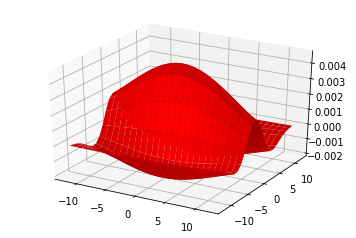

In [81]:
X,Y=np.meshgrid(np.linspace(-12,12,25),np.linspace(-12,12, 25));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, weights, color='red')
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [52]:
np.mean([np.mean(convolve(tile[:, :, i], weights)) for i in range(3)])

0.00013765982813667972

In [58]:
def DOOG_mean(img, weights):
    return np.mean([np.mean(convolve(img[:, :, i], weights)) for i in range(3)])

In [60]:
DOOG_mean(tile, weights)

0.00013765982813667972

In [ ]:
# maybe too small?

In [68]:
np.max(DOOG2_weight(1))

0.041748393641227621

In [69]:
np.max(DOOG2_weight(3))

0.0046387104045808461

In [70]:
np.max(DOOG2_weight(7))

0.00085200803349444118

In [72]:
np.max(DOOG2_weight(7)/  np.linalg.norm(DOOG2_weight(7)))

0.052987915559242309

In [71]:
# https://github.com/pdollar/toolbox/blob/master/filters/FbMake.m
# 0.5, 1, 1.5, 2.0

In [82]:
[np.max(convolve(tile[:, :, i], weights)) for i in range(3)]

[0.071272975969383937, 0.022219196106824542, 0.036144642500056459]

In [83]:
[np.mean(convolve(tile[:, :, i], weights)) for i in range(3)]

[0.00043807751520494033, 0.00071622558181795083, 0.00096152301023888064]

In [84]:
[np.mean(convolve(tile[:, :, i], weights))*1000 for i in range(3)]

[0.43807751520494032, 0.71622558181795082, 0.96152301023888065]

In [63]:
np.max(weights)

0.041748393641227621

In [66]:
# np.max(weights / np.linalg.norm(weights))

0.36606071769805038

# Orientation Filter

In [93]:
from scipy.stats import norm

In [106]:
def DOG(y, sigma1=0.5, sigma2=1.5):
    fy1 = norm.pdf(y, scale=sigma1)
    fy2 = norm.pdf(y, scale=sigma2)
    dog = fy1 - fy2
    return dog

In [107]:
dog = DOG(np.arange(-5, 5, 0.1))

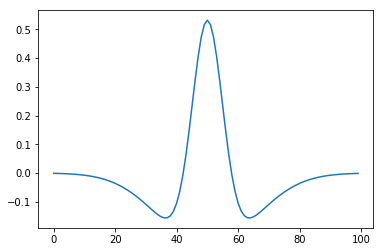

In [108]:
plt.plot(dog)

In [113]:
np.arange(5).reshape(5, 1)*np.arange(5,10).reshape(1, 5)

array([[ 0,  0,  0,  0,  0],
       [ 5,  6,  7,  8,  9],
       [10, 12, 14, 16, 18],
       [15, 18, 21, 24, 27],
       [20, 24, 28, 32, 36]])

In [122]:
np.arange(5).reshape(1, 5)*np.arange(5,10).reshape(5, 1)

array([[ 0,  5, 10, 15, 20],
       [ 0,  6, 12, 18, 24],
       [ 0,  7, 14, 21, 28],
       [ 0,  8, 16, 24, 32],
       [ 0,  9, 18, 27, 36]])

In [126]:
(np.arange(5).reshape(1, 5)*np.arange(5,10).reshape(5, 1))[1][3]

18

In [127]:
np.arange(3).reshape(1, 3)*np.arange(5,10).reshape(5, 1)

array([[ 0,  5, 10],
       [ 0,  6, 12],
       [ 0,  7, 14],
       [ 0,  8, 16],
       [ 0,  9, 18]])

In [112]:
np.arange(5).reshape(1, 5)[0]

array([0, 1, 2, 3, 4])

In [114]:
sigmax = 1

In [115]:
x = np.arange(-5, 5, 0.1)

In [128]:
fx = norm.pdf(x, scale=sigmax).reshape(1, len(x))

In [129]:
y = np.arange(-7, 7, 0.1)

In [130]:
fy = DOG(y).reshape(len(y), 1)

In [136]:
f1 = fx*fy
# should access f1[y][x]

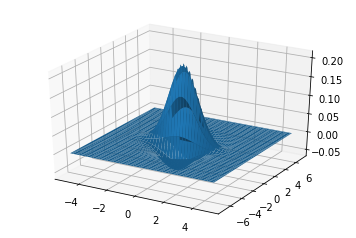

In [134]:
X,Y=np.meshgrid(np.linspace(-5,5,len(x)),np.linspace(-7,7, len(y)));
fig=plt.figure();
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(X, Y, f1)
# ax.plot_surface(X, Y, fx*fy, color='red')
# surf=ax.plot_surface(X,Y,G,c='red')
plt.show()

In [137]:
from scipy.signal import hilbert

In [138]:
f2 = np.imag(hilbert(f1))

In [139]:
f2.shape

(140, 100)

In [140]:
f1.shape

(140, 100)

# Try and Error

In [ ]:
tmp = norm.pdf(np.arange(-10, 10, 0.1), scale=5)
plt.plot(np.arange(-10, 10, 0.1), tmp)

In [11]:
calc_moments(tile[:, :, 0])

(0.37209400017472155, 0.10217063437619424, -0.09780083132038393)

In [21]:
color.rgb2gray(tile[0:3, 0:3, :])

array([[ 0.51498902,  0.51498902,  0.51498902],
       [ 0.51498902,  0.51498902,  0.51498902],
       [ 0.51777176,  0.51777176,  0.51777176]])

In [26]:
tmp = tile[0:3, 0:3, :]

In [27]:
[calc_moments(tmp[:, :, i]) for i in range(3)]

[(0.25882352941176467, 0.0055459355387180269, 0.15959603823333823),
 (0.56470588235294117, 0.0, -0.241661910774848),
 (0.78954248366013069, 0.0018486451795726665, -0.44268744485027073)]

In [28]:
len(calc_4_moments(tmp))

12

In [29]:
calc_4_moments(tile)

[0.37209400017472155,
 0.10217063437619424,
 -0.09780083132038393,
 0.60834722741120328,
 0.069683966722592888,
 -0.2781541238099151,
 0.8166978005535328,
 0.05321479042159858,
 -0.4683674599313368,
 0.5731654929470128,
 0.073980597551597832,
 -0.2485871934295749]

In [19]:
def gray_arr(rgbarr):
    return (rgbarr[:, :, 0]+rgbarr[:, :, 1]+rgbarr[:, :, 2])/3

In [20]:
gray_arr(tile[0:3, 0:3, :])

array([[ 0.53594771,  0.53594771,  0.53594771],
       [ 0.53594771,  0.53594771,  0.53594771],
       [ 0.54117647,  0.54117647,  0.54117647]])

In [21]:
tile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]])

In [22]:
tile[0:3, 0:3, 1]

Image([[144, 144, 144],
       [144, 144, 144],
       [144, 144, 144]])

In [23]:
tile[0:3, 0:3, 2]

Image([[201, 201, 201],
       [201, 201, 201],
       [202, 202, 202]])

In [24]:
(tile[0:3, 0:3, 0]+tile[0:3, 0:3, 1]+tile[0:3, 0:3, 2])/3

Image([[ 136.66666667,  136.66666667,  136.66666667],
       [ 136.66666667,  136.66666667,  136.66666667],
       [ 138.        ,  138.        ,  138.        ]])

In [9]:
r_1_moment = np.mean(tile[:, :, 0])

In [10]:
r_1_moment

94.88397004455399

In [11]:
np.sum(tile[:, :, 0])/(tile.shape[0]*tile.shape[1])

94.88397004455399

In [12]:
import math

In [13]:
np.sum((tile[:, :, 0]-r_1_moment)**2)/(tile.shape[0]*tile.shape[1])

678.78547533742858

In [14]:
np.mean((tile[:, :, 0]-r_1_moment)**2)

678.78547533742858

In [15]:
r_2_moment = np.mean((tile[:, :, 0]-r_1_moment)**2)**(1/2)

In [16]:
r_2_moment

26.053511765929532

In [73]:
math.sqrt(np.mean((tile[:, :, 0]-r_1_moment)**2))

26.05351176592953

In [81]:
r_3_moment = (np.mean((tile[:, :, 0]-r_1_moment)**3))**(1./3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [68]:
r_3_moment

nan

In [91]:
np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float)

-15511.299389127838

In [85]:
type(np.mean((tile[:, :, 0]-r_1_moment)**3))

numpy.float64

In [82]:
r_3_moment = np.power(np.mean((tile[:, :, 0]-r_1_moment)**3), 1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


In [88]:
r_3_moment = np.power(np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float), 1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in power
  """Entry point for launching an IPython kernel.


In [89]:
r_3_moment

nan

In [105]:
-15511.299389127838**(1/3)

-24.93921198669789

In [100]:
(-15511.299389127838)**(1/3)

(12.46960599334895+21.597991130845752j)

In [95]:
np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float)

-15511.299389127838

In [97]:
(np.mean((tile[:, :, 0]-r_1_moment)**3).astype(float))**(1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

Negative cuberoot return complex answer (it also valid from the methematical point of view, but not what people want)

- https://stackoverflow.com/questions/1361740/cubic-root-of-the-negative-number-on-python
- https://stackoverflow.com/questions/45906383/python-exponent-operator-with-fractional-exponents

In [107]:
calc_moment3(tile[:, :, 0], r_1_moment)

-24.93921198669789

In [108]:
r_3_moment = moment3(tile[:, :, 0], r_1_moment)

In [109]:
r_1_moment, r_2_moment, r_3_moment

(94.88397004455399, 26.053511765929532, -24.93921198669789)

In [113]:
calc_moments(tile[:, :, 1])

(155.12854298985687, 17.769411514261186, -70.92930157152836)

In [114]:
calc_moments(tile[:, :, 2])

(208.25793914115081, 13.569771557507638, -119.4337022824908)

In [32]:
tmp = np.array([3, 4, 5])

In [33]:
tmp**2

array([ 9, 16, 25])

In [34]:
tmp**3

array([ 27,  64, 125])

In [39]:
itile = tile.astype(int)

In [43]:
tile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]], dtype=uint8)

In [40]:
itile[0:3, 0:3, 0]

Image([[65, 65, 65],
       [65, 65, 65],
       [68, 68, 68]])

In [41]:
itile[0:3, 0:3, 0]**2

Image([[4225, 4225, 4225],
       [4225, 4225, 4225],
       [4624, 4624, 4624]])

In [42]:
itile[0:3, 0:3, 0]**3

Image([[274625, 274625, 274625],
       [274625, 274625, 274625],
       [314432, 314432, 314432]])